# Introducción al manejo de datos geográficos

# Clase 4

##  Parte 3. OSMnx
### Calles y límites: trabajando el callejero como una red de nodos y arcos. 

#### Algunos conceptos básicos

Si recordamos nuestra clase anterior, llamamos grafo a un tipo de estructura de datos compuesta por un conjunto de nodos o vértices unidos a través de ejes o arcos. Algo que resulta particularmente práctico para diagramar redes de distinto tipo. 

OSMnx es una librería de python que permite construir redes de calles a partir de la API de [OpenStreeMap](https://www.openstreetmap.org). Utilizando, ya sea geometrías provistas como argumentos o bien coordenadas específicas, esta permite tanto la reproyección como la visualización del objeto resultante.

Para ello, trabaja básicamente a partir de la librería que vimos en el encuentro anterior: [NetworkX](https://networkx.github.io/documentation/stable/)

Acá disponibilizamos la [documentación oficial](https://osmnx.readthedocs.io/en/stable/index.html) y acá algunas [demostraciones de uso](https://github.com/gboeing/osmnx-examples/tree/master/notebooks) a cargo de [gboeing](https://geoffboeing.com/about/). Esta clase también se apoya en el presente [material](https://github.com/smmaurer/cp255/tree/master/07-street-networks) realizado por [Sam Maurer](http://samuelmaurer.info/) sobre redes de calles.

Este módulo no lo hemos incluido en el `requirements` del curso, asique instalemoslo manualmente desde el mismo notebook. De la siguiente manera,

In [1]:
%%capture
#!pip install osmnx>=0.13
#!pip install install ipython==7.10.0

En la propuesta que preparamos para esta clase, vamos enfocarnos en dos de las principales funcionalidades de `OMSNx`. En primeria instancia, vamos a revisar algunos de sus métodos para definir un escenario territorial específico. Es decir, vamos a ver cómo trabajar con geometrias. Una vez repasado esto, nos vamos a adentrar en cuestiones específicas del análisis y descripción de una red de calles.

Algo interesante de `OSMnx` es que se pueden ajustar algunas configuraciones relacionadas a su uso desde el método `.config()`. Acá compartimos [el detalle de las mismas](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils.config).

Nosotros vamos a definir los parametros `log_file`, `log_console` y `use_cache` como `True` porque:


* log_file (bool) – if True, save log output to a file in logs_folder

* log_console (bool) – if True, print log output to the console (terminal window)

* use_cache (bool) – if True, cache HTTP responses locally instead of calling API repeatedly for the same request


Si, por ejemplo, hubiesemos setado `use_cache` como `False` OSMnx no guardaria las respuestas del server para evitar llamarlo repetidamente en la misma query cada vez que se ejecuta algún método. Este tipo de configuraciones se pueden ajustar manualmente desde `config`. Cualquier parámetro no especificado tomara el valor por default del método).

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import osmnx as ox
print(ox.__version__)
ox.config(log_file=True, log_console=True, use_cache=True)

1.0.1


## Sección 1: Descargando geometrías

### 1.1. Entidades territoriales

Antes de comenzar a trabajar con calles, debemos saber que OSMNx nos permite descargar distintos tipos de entidades con el módulo `geometries`. A través del mismo, se pueden consultar desde paradas de tránsito a distintos puntos de intéres como escuelas, negocios, edificios, barrios, etc.

Para hacer una consulta a la API, debemos utilizar un diccionario con tags de OSM. Este debe especificar un string con el nombre del tag como key. 

Respecto de los values, estos pueden ser un booleano para devolver todos los objetos que en Openstreet usan dicho tag. También puede ser otro string con el nombre de una subcategoría con la que matchea el tag que seteamos en la key, o una lista de strings para devolver al menos alguna de las subcategorías con las que queremos que matchee nuestro tag.

In [3]:
# digamos que queremos consultar entidades que hayan sido taggeadas como edificios
localidad = 'José León Suárez, Partido de General San Martín, Buenos Aires, Argentina'
tags = {'building': True} 

edificios = ox.geometries_from_place(localidad, tags)
edificios.shape

(142, 30)

In [4]:
# ... y ahora las que tengan un tag asociado a usos de suelo específicos. Digamos viviendas y basurales...
tags = {'landuse': ['residential','landfill']}

usos_suelo = ox.geometries_from_place(localidad, tags)
usos_suelo.shape

(14, 12)

In [5]:
# por ultimo, busquemos por una subcategoría en concreto. Por ejemplo, el barrio "Villa Hidalgo"
tags = {'name':'Villa Hidalgo'}
vh = ox.geometries_from_place(localidad, tags)
vh.shape

(2, 9)

In [6]:
vh

,unique_id,osmid,element_type,name,place,geometry,nodes,landuse,source
0,node/3825897569,3825897569,node,Villa Hidalgo,neighbourhood,POINT (-58.58055 -34.51362),NaN,NaN,NaN
1,way/525210889,525210889,way,Villa Hidalgo,NaN,"POLYGON ((-58.58923 -34.51020, -58.58820 -34.5...","[5109775665, 5109775666, 5109775667, 510977566...",residential,Registro_Provincial_de_Barrios_Populares


Veamos en qué consisten las geometrías que hemos descargado desde OSM!

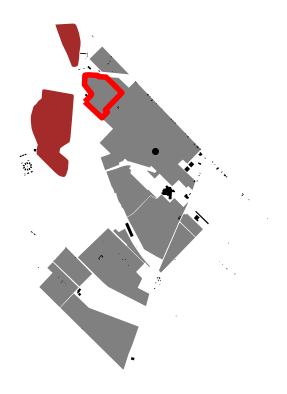

In [7]:
f, ax = plt.subplots(figsize=(12,7))

# preparamos nuestros layers
vh_polyg = vh[vh.geometry.apply(lambda x: x.type == 'Polygon')] # nos quedamos con la entidad que es un polígono!
usos_residenciales = usos_suelo.loc[usos_suelo.landuse == 'residential']
basurales = usos_suelo.loc[usos_suelo.landuse == 'landfill']

# ploteamos
usos_residenciales.plot(ax=ax, color='grey')
vh_polyg.geometry.boundary.plot(ax=ax, color='red', linewidth=5.5)
basurales.plot(ax=ax, color='brown')
edificios.plot(ax=ax, color='black')

ax.set_axis_off();

### 1.2. Límites territoriales desde OpenStreetMap

A través del método `geocode_to_gdf`, OSMnx también permite descargar geometrías a partir de los límites de un lugar específico, reproyectarlas y también plotearlas.

In [8]:
# consultamos el polígono de la localidad de José León Suárez
limite_localidad = ox.geocode_to_gdf(localidad)
localidad_proj = ox.project_gdf(limite_localidad)

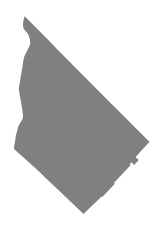

In [9]:
ax = localidad_proj.plot(facecolor='gray', edgecolor='none')
ax.axis('off');

In [10]:
limite_localidad

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-58.60490 -34.53010, -58.59701 -34.5...",-34.490188,-34.549987,-58.55555,-58.6049,259611343,relation,9166483,-34.532869,-58.575535,"José León Suárez, Partido de General San Martí...",boundary,administrative,1.381597


Como se puede ver, utilizamos el metodo `project_gdf`. Lo que hace si no se especifica ningún CRS, automáticamente reproyecta en UTM tomando como referencia el centroide del GeoDataFrame en la zona desde donde fue descargado.

El método `geocode_to_gdf` también permite hacer consultas masivas. Esto especificando los límites territoriales a partir de una lista de ubicaciones. Veamos cómo...

In [11]:
# cargamos múltiples geografías
localidades = ['José León Suárez, Partido de General San Martín, Buenos Aires, Argentina', 
               'Loma Hermosa, Partido de General San Martín, Buenos Aires, Argentina',
               'Villa Ballester, Partido de General San Martín, Buenos Aires, Argentina']
sm_norte = ox.geocode_to_gdf(localidades)
sm_norte = ox.project_gdf(sm_norte)

In [12]:
sm_norte

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((352710.963 -3822104.738, 353445.474 ...",-34.490188,-34.549987,-58.555550,-58.604900,259611343,relation,9166483,-34.532869,-58.575535,"José León Suárez, Partido de General San Martí...",boundary,administrative,1.381597
1,"POLYGON ((351519.100 -3824046.043, 352150.059 ...",-34.530103,-34.568882,-58.582404,-58.618221,259381103,relation,9166554,-34.549237,-58.599366,"Loma Hermosa, Partido de General San Martín, B...",boundary,administrative,1.345429
2,"POLYGON ((354330.275 -3825595.685, 354332.732 ...",-34.528617,-34.571098,-58.537737,-58.587860,259611351,relation,9166567,-34.548381,-58.556492,"Villa Ballester, Partido de General San Martín...",boundary,administrative,1.399564


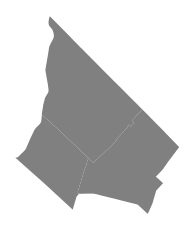

In [13]:
ax = sm_norte.plot(facecolor='gray', edgecolor='none')
ax.axis('off');

## Sección 2: Construyendo redes de calles

OSMnx también cuenta con un módulo específico de grafos - [acá el hipervínculo para revisar todos sus métodos](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.graph) - que permite descargar una red de calles desde la API de OSM y modelarla a partir de diferentes tipologías. Los nodos se establecen a partir de la intersección de calles, mientras que los ejes o arcos que los unen son las calles en sí mismas. Existen diversas maneras de descargar una red de calles, ya sea desde un conjunto de coordenadas, un polígono específico o directamente el nombre de una unidad administrativa registrada. A lo largo del notebook iremos explorando cada una de ellas.

A su vez, cada uno de estos métodos nos brindarán la posibilidad de definir diferentes tipos de redes:

* 'drive' - calles o vias de tránsito públicas (sin contar colectoras o caminos paralelos)
* 'drive_service' - calles de tránisto, incluyendo colectoras )o service roads=
* 'walk' - calles y caminos también disponibles para peatones (este tipo de red ignora la direccionalidad)
* 'bike' - calles y caminos con bicisendas
* 'all' - descarga cualquier tipo de calle o camino público
* 'all_private' - descarga cualquier tipo de calle o camino, inluyendo los de acceso privado.

### 2.1. Calles a partir de coordenadas específicas

El método `graph_from_bbox` permite consultar todos los nodos y calles de la API de OSM dentro de un recuadro delimitado por un conjunto de coordenadas arbitrarias. Existen varias herramientas para consultar coordenadas de algún lugar que nos interese, [bbox finder](http://bboxfinder.com/) es una de ellas. 

Ahora vamos a consultar las coordenadas del polígono que contiene algunos asentamientos informales del partido de San Martín, en la provincia de Buenos Aires. [Delimitemos Villa Hidalgo y La Cárcova](http://bboxfinder.com/#-34.533783,-58.589787,-34.506274,-58.566399)

In [14]:
# establecemos un conjunto de coordenadas arbitrarias
norte, sur, este, oeste = -34.506274, -34.533818, -58.566442, -58.589830

# instanciamos nuestro grafo con bounding box
G = ox.graph_from_bbox(norte, sur, este, oeste, network_type='drive_service')

In [15]:
# Vemos que es un grafo dirigido!
type(G)

networkx.classes.multidigraph.MultiDiGraph

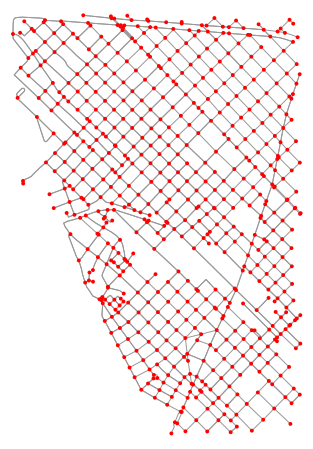

In [16]:
fig, ax = ox.plot_graph(G, bgcolor='w',node_color='r')

Otra alternativa para consultar redes de calles a partir de conjuntos de coordenadas es utilizar localizaciones específcias. Es decir, en lugar de definir un polígono determinado, utilizar un punto de referencia. Esto se consigue con el método `graph_from_point` y lo que hace es crear un *bounding box* o marco de referencia *n* metros hacia el norte, sur, este y oeste según lo determinemos en el parámetro `dist`. 

In [17]:
# creamos una tupla en el centroide de Villa Hidalgo
referencia = (-34.50944,-58.58610)

# a partir del punto de referencia previo, se construye una red dentro de un marco de 500m hacia el N,S,E y O.
G2 = ox.graph_from_point(center_point=referencia, dist=500, dist_type='bbox', network_type='drive')

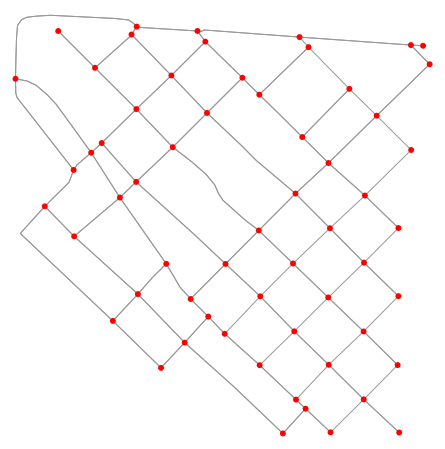

In [18]:
fig2, ax2 = ox.plot_graph(G2, bgcolor='white', node_color='red', node_size=35)

Si prestan atención, verán que utilizamos el parámetro `dist_type`. Además del valor *bbox* este nos ofrece la opción *network* ...

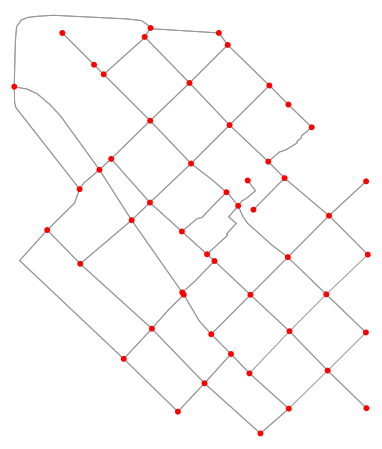

In [19]:
G3 = ox.graph_from_point(center_point=referencia, dist=500, dist_type='network')
fig3, ax3 = ox.plot_graph(G3, bgcolor='white', node_color='red', node_size=35)

En el ejemplo anterior hicimos dos modificaciones. Primero, cambiamos el tipo de distancia. Segundo, utilizamos el default de `network_type`.

Aclaremos primero esto último. Cuando utilizamos *all_private* (que es el valor por defecto) para definir el tipo de red, no estamos filtrando o exluyendo vías que restringen la circulación para determinado tipo de tráfico. Pueden ver que en el último plot, se agregan algunas calles de traza irregular. Es decir, ampliamos las posibilidades de circulación.

La diferencia respecto de utilizar *bbox*, es que *network* remueve los nodos más allá de *n* metros de distancia a lo largo de la red desde el punto que tomamos como referencia. Es decir, en ambas opciones se establece un marco espacial hacia el norte, sur, este y oeste del mismo y luego se construye la red con todos los nodos y vías disponibles en la API de OSM dentro del marco establecido. Pero si utilizamos *network*, los nodos más allá de cierta distancia de viaje (o distancia dentro de la red) serán removidos. 

También es importante remarcar que al ser *network* el tipo de distancia se respeta el sentido de las calles. En el caso de nuestro ejemplo, el radio de 500 metros de distancia que establecimos toma en cuenta los nodos a los que se puede llegar desde el punto de referencia viajando en el sentido permitido y no en el contrario.

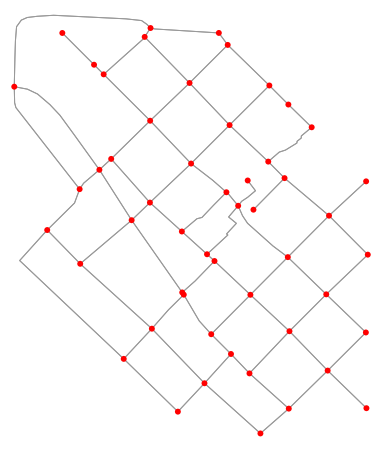

In [20]:
# creamos una nueva red de calles, esta vez restringiendola a vias caminables
G4 = ox.graph_from_point(center_point=referencia, dist=500, dist_type='network', network_type='walk')
fig4, ax4 = ox.plot_graph(G4, bgcolor='white', node_color='red', node_size=35)

Al definir el tipo de red como *walk*, hacemos que los ejes sean solamente calles donde está permitido caminar. En otras palabras, construimos un grafo dirigido con vínculos bidireccionales entre nodos. Básicamente, porque se puede llegar a cualquier intersección en ambas direcciones del sentido único de la calle. Por lo tanto, los 500 m ahora tienen en cuenta los nodos a los que puede llegar mientras viaja en cualquier dirección (incluso si es una calle de un solo sentido).

### 2.2. Calles a partir de nombres y geometrías

Además del uso de coordenadas, OSMNx permite consultar calles que responden a nombres específicos o que se encuentran dentro de los límites de polígonos que especifiquemos.

En el primer caso, al pasar el nombre de una calle, esta se geocodifica y se crea un marco espacial o bounding box. Luego se descarga la red lista para trabajar como vimos en los ejemplos anteriores. También se puede especificar el nombre de la localidad, partido o unidad administrativa cuya red de calles nos resulte de interés.

In [21]:
# definimos una direccion de referencia
direccion = 'Pedro Segui 1523, José León Suárez, Partido de General San Martín, Buenos Aires, Argentina'

In [22]:
G5 = ox.graph_from_address(address= direccion,
                           dist=1000, dist_type='network', network_type='drive')

# así como vimos con la descarga de geometrías, los grafos también pueden ser reproyectados en UTM
G5_prj = ox.project_graph(G5)

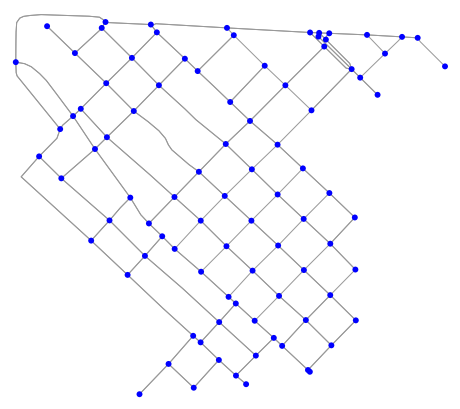

In [23]:
fig5, ax5 = ox.plot_graph(G5_prj,  bgcolor='white', node_color='blue', node_size=35)

En este caso, lo que estamos haciendo es crear una red a partir de una calle y altura específicas. Eso se toma como punto de referencia y se consideran solamente los nodos que están a 1km de distancia desde esa dirección a lo largo de la red.

Como mencionamos, además del método `graph_from_adress`, también se puede utilizar `graph_from_place`. Esto con el objetivo de indicar el nombre del lugar en el que estemos interesados. El cual puede ser ...

In [24]:
# algún barrio o asentamiento 
G6 = ox.graph_from_place('Villa Hidalgo, José León Suárez, Partido de General San Martín, Buenos Aires', 
                         network_type='walk')

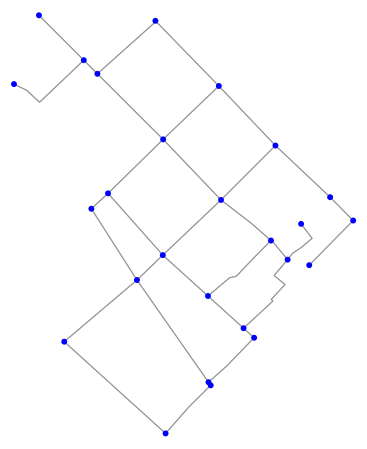

In [25]:
fig6, ax6 = ox.plot_graph(G6, bgcolor='white', node_color='blue', node_size=35)

In [26]:
G7 = ox.graph_from_place('Villa La Carcova, Partido de General San Martín, Buenos Aires', 
                         network_type='walk')

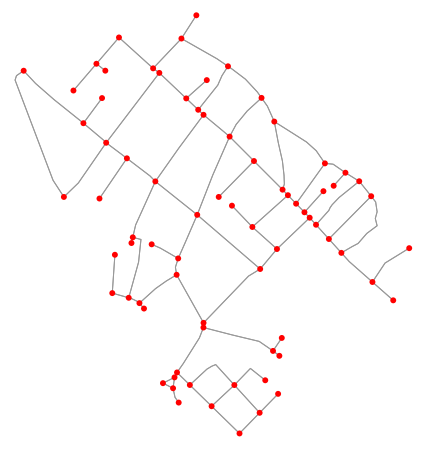

In [27]:
fig7, ax7 = ox.plot_graph(G7, bgcolor='white', node_color='red', node_size=35)

In [28]:
# o directamente el nombre de alguna unidad administrativa
localidades

['José León Suárez, Partido de General San Martín, Buenos Aires, Argentina',
 'Loma Hermosa, Partido de General San Martín, Buenos Aires, Argentina',
 'Villa Ballester, Partido de General San Martín, Buenos Aires, Argentina']

In [29]:
# en este caso, vemos que pasamos una lista con las tres localidades que definimos al inicio
places = localidades[0:2]
G8 = ox.graph_from_place(places, clean_periphery=False)

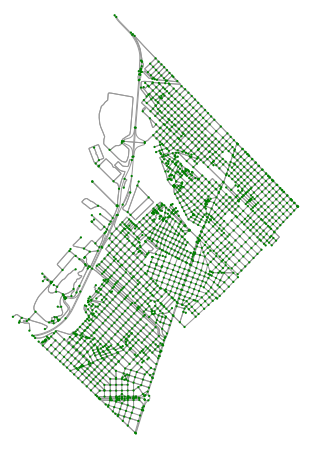

In [30]:
fig8, ax8 = ox.plot_graph(G8, bgcolor='white', node_color='green', node_size=5)

Por último, vamos a mencionar el método `graph_from_polygon`. Vimos que podemos construimos grafos a partir de nombres de calles o lugares específicos. Este método nos permite hacer lo mismo, pero con la diferencia de ser nosotros los que definimos a partir de una geometría los límites de descarga de nuestra red.

In [31]:
barrios = gpd.read_file('../carto/renabap.geojson')

# nos quedamos con los barrios de San Martin
barrios_sm = barrios.loc[(barrios.provincia == 'Buenos Aires') & (barrios.departamen == 'General San Martín')]

In [32]:
# y ahora con algunos de jose leon suarez
barrios_ls = barrios_sm.loc[(barrios_sm.nombre_bar == 'Villa Hidalgo')|
                            (barrios_sm.nombre_bar == 'La Carcova')].copy()

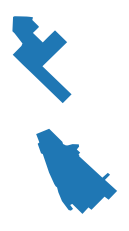

In [33]:
f, ax = plt.subplots()
barrios_ls.plot(ax=ax)
ax.set_axis_off();

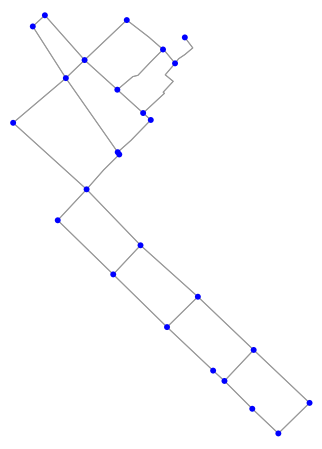

In [34]:
# Villa Hidalgo
vh = barrios_ls['geometry'].iloc[0]
G9 = ox.graph_from_polygon(vh, network_type='walk')

fig9, ax9 = ox.plot_graph(G9, bgcolor='white', node_color='blue', node_size=35)

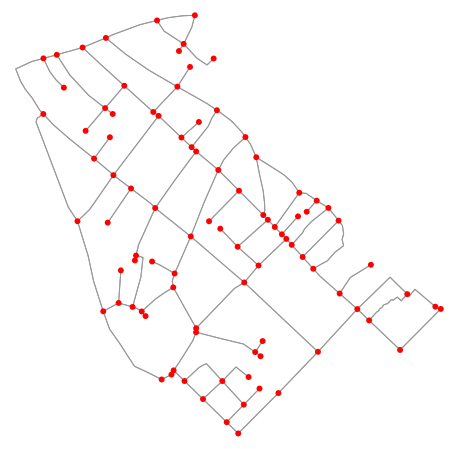

In [35]:
# La Carcova
lc = barrios_ls['geometry'].iloc[1]
G10 = ox.graph_from_polygon(lc, network_type='walk')

fig10, ax10 = ox.plot_graph(G10, bgcolor='white', node_color='red', node_size=35)